In [ ]:
# LAst amended: 13th April, 2025
# RAG with csv files
# USes ollama models, ollama embeddings and chroma vector store

In [ ]:
# References:
#            
#            https://docs.llamaindex.ai/en/stable/examples/embeddings/ollama_embedding/
#            https://docs.llamaindex.ai/en/stable/examples/llm/ollama/
#            https://docs.llamaindex.ai/en/stable/module_guides/supporting_modules/settings/
#            https://howaibuildthis.substack.com/p/llamaindex-how-to-use-index-correctly

## What is [LlamaIndex](https://github.com/run-llama/llama_index)

### Context

>1. LLMs are a phenomenal piece of technology for knowledge generation and reasoning. They are pre-trained on large amounts of publicly available data.      
>2. How do we best augment LLMs with our own private data?

We need a comprehensive toolkit to help perform this data augmentation for LLMs.     

><b>Proposed Solution</b>      

That's where LlamaIndex comes in. LlamaIndex is a <b><i>"data framework"</i></b> to help you build LLM apps. It provides the following tools:

>1. Offers <i>data connectors</i> to ingest your existing data sources and data formats (APIs, PDFs, docs, SQL, etc.).     
>2. Provides <i>ways to structure your data</i> (indices, graphs) so that this data can be easily used with LLMs.     
>3. Provides an <i>advanced retrieval/query interface</i> over your data: Feed in any LLM input prompt, get back retrieved context and knowledge-augmented output.     
>4. Allows <i>easy integrations with your outer application framework</i> (e.g. with LangChain, Flask, Docker, ChatGPT, or anything else).     

LlamaIndex provides tools for both beginner users and advanced users. Our high-level API allows beginner users to use LlamaIndex to ingest and query their data in 5 lines of code. Our lower-level APIs allow advanced users to customize and extend any module (data connectors, indices, retrievers, query engines, reranking modules), to fit their needs.

### Imports & Environment Variables 

In [70]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
# 1.0
import nest_asyncio
nest_asyncio.apply()

In [2]:
# 1.0 SimpleDirectoryReader can also load metadata from a dictionary
#     https://docs.llamaindex.ai/en/stable/module_guides/loading/simpledirectoryreader/
from llama_index.core.readers import SimpleDirectoryReader
from llama_index.readers.file import PagedCSVReader

# 1.1 The Settings is a bundle of commonly used resources used 
#     during the indexing and querying stage in a LlamaIndex workflow/application.
from llama_index.core import Settings

# 1.2 If using LocalAI
# https://docs.llamaindex.ai/en/stable/examples/llm/localai/
from llama_index.llms.openai_like import OpenAILike

# 1.3 Ollama related
# https://docs.llamaindex.ai/en/stable/examples/embeddings/ollama_embedding/
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.llms.ollama import Ollama


# 1.4 Vector store related
import chromadb
from llama_index.core import StorageContext
from llama_index.core import VectorStoreIndex
from llama_index.vector_stores.chroma import ChromaVectorStore

# 1.5 Misc
import os
import pandas as pd

/home/ashok/langchain/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 2.0 Define embedding function

# embed_model = HuggingFaceEmbedding(
#                                     model_name="BAAI/bge-base-en-v1.5"
#                                    )

embed_model= OllamaEmbedding(
                                    model_name="nomic-embed-text",      # Using foundational model may be overkill
                                    base_url="http://localhost:11434",
                                    #dimensions=512,
                                    #ollama_additional_kwargs={"mirostat": 0},
                                  )

Settings.embed_model = embed_model

In [4]:
# 2.1 Settings can set the global configuration. Local configurations (transformations, LLMs, embedding models).
#     These can be passed directly into the interfaces that make use of them.



"""
llm1 = Ollama(
                        model="llama3.2:latest",
                        request_timeout=120.0,
                        temperature = 0.0,
                        mirostat = 0)

"""
"""
# Takes a lot of time but the output is better
Settings.llm = OpenAILike(
                          temperature=0.7,
                          model= "LocalAI-functioncall-phi-4-v0.3",  #"llama-3.2-3b-instruct:q8_0" , # "gemma-3-12b-it", # "LocalAI-functioncall-phi-4-v0.3", # "gpt-3.5-turbo",  # "gemma-3-27b-it",  #          # Can be any name, not necessarily openai's gpt
                          api_base="http://127.0.0.1:8080/v1",
                          api_key="fake",
                          timeout= 1000.0,
                          is_chat_model = True,
                          is_function_calling_model=True,
                          )
"""

"""
============
from llama_index.llms.groq import Groq
# Following LLM gives good results
llm = Groq(
            model= "qwen-qwq-32b", #         "llama-3.3-70b-versatile",
            api_key="gsk_vpbDWvcFqweqweYq2QQcn6rXgQiOrOjQ6QhXeNh",
            temperature = 0.5,
        )
==========
"""

## Very very fast and Excellent
# pip install llama-index-llms-mistralai
from llama_index.llms.mistralai import MistralAI
llm = MistralAI(api_key="Vcv20x3123wi7bmBbtrtterterxZ6SiNJzkh35ZOWvM")
Settings.llm = llm

### Settings 
Stores global/local configuration      
In earlier versions of llamaindex, [ServiceContext](https://docs.llamaindex.ai/en/v0.9.48/module_guides/supporting_modules/service_context.html#servicecontext) was used for this purpose

In [5]:
# Write: Settings.<press tab>

print(f"Node Parser: {Settings.node_parser}\n")
print(f"Text Splitter: {Settings.text_splitter}\n")  # Same as Node Parser

print(f"Chunk Size: {Settings.chunk_size}\n")
print(f"Chunk Overlap: {Settings.chunk_overlap}\n")

# The tokenizer is used to count tokens. 
#  This should be set to something that matches the LLM you are using.
#   See here: # https://docs.llamaindex.ai/en/stable/module_guides/supporting_modules/settings/#tokenizer
print(f"Tokenizer: {Settings.tokenizer}\n")  

# maximum input size to the LLM
print(f"Context_window: {Settings.context_window}\n")   

# number of tokens reserved for text generation.
print(f"Max tokens output: {Settings.num_output}\n")  

# Default LLM
print(f"Default LLM: {Settings.llm}\n")  

# DEfault embedding model
print(f"Default embed_model: {Settings.embed_model}\n")  



Node Parser: include_metadata=True include_prev_next_rel=True callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x7f9d66676050> id_func=<function default_id_func at 0x7f9cdc07a290> chunk_size=1024 chunk_overlap=200 separator=' ' paragraph_separator='\n\n\n' secondary_chunking_regex='[^,.;。？！]+[,.;。？！]?'

Text Splitter: include_metadata=True include_prev_next_rel=True callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x7f9d66676050> id_func=<function default_id_func at 0x7f9cdc07a290> chunk_size=1024 chunk_overlap=200 separator=' ' paragraph_separator='\n\n\n' secondary_chunking_regex='[^,.;。？！]+[,.;。？！]?'

Chunk Size: 1024

Chunk Overlap: 200

Tokenizer: functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all')

Context_window: 32000

Max tokens output: 512

Default LLM: callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x7f9d66676050> system_prompt=None messages_to_

### Load and Process CSV Data as Document

In [6]:
# 3.0 Reading data in pandas
#     It has nothing to do with subsequent analysis/usage

file_path = ('/home/ashok/Documents/csvrag/data/data.csv') # insert the path of the csv file
#file_path = ('/home/ashok/Downloads/csvrag/data/data.csv') # insert the path of the csv file
df = pd.read_csv(file_path)

# 3.1 Preview the csv file
df.head()

,Roll_Number,fullName,Gender,BirthDate,age,MBA CGPA,garduation college,University,Degree,Specialization,percentage marks obtained during graduation,year when graduation was completed,name of the school attended for class 12,education board for class 12,academic stream chosen in class 12,percentage marks scored in class 12
0,1,Amit Sharma,Male,5/14/2002,23,6.69,Vivekananda Institute Of Professional Studies,Guru Gobind Singh Indraprastha University,B.C.A.,Computer Applications,53.83,2021,Holy Convent School,CBSE,Commerce,79.33
1,2,Pooja Verma,Female,8/25/1998,27,7.53,Asutosh College,Rajiv Gandhi Proudyogiki Vishwavidyalaya,B.E.,Biology,68.35,2020,Kishinchand Chellaram College,CBSE,Science,92.60
2,3,Rahul Kumar,Female,3/26/2002,23,7.70,St. Xavier'S College,Amity University,B.Com. (Hons.),Finance,74.16,2022,Delhi Public School,CBSE,Commerce,85.33
3,4,Neha Agarwal,Male,8/15/1997,26,5.82,School Of Commerce,Jaypee Institute Of Information Technology,B.Tech,Electronics And Communication Engineering,68.00,2019,G.A.V. Public School,CBSE,Science (Non-Medical),80.33
4,5,Rohan Das,Male,8/16/1999,25,6.80,Government Engineering College,Vellore Institute Of Technology,B.A. (Hons.),Economics,64.24,2021,Summer Fields School,CBSE,Science (Medical),67.60


### One way
Directly read csv file

In [7]:
# 4.0 PagedCSVReader displays each row in an LLM-friendly format. Each row as a separate document.
csv_reader = PagedCSVReader()

# 4.1
reader = SimpleDirectoryReader( 
                                input_files=[file_path],
                                file_extractor= {".csv": csv_reader}
                               )

# 4.2
docs = reader.load_data()

In [8]:
# 4.3 Look at Documents
display(len(docs))

print("\n============\n")

display(docs[:2])   # List of Document

500

[Document(id_='66fdc1cf-4655-4bc5-87fd-f5aa6067ea24', embedding=None, metadata={'file_path': '/home/ashok/Documents/csvrag/data/data.csv', 'file_name': 'data.csv', 'file_type': 'text/csv', 'file_size': 96934, 'creation_date': '2025-03-23', 'last_modified_date': '2025-03-23'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='Roll_Number: 1\nfullName: Amit Sharma\nGender: Male\nBirthDate: 5/14/2002\nage: 23\nMBA CGPA: 6.69\ngarduation college: Vivekananda Institute Of Professional Studies\nUniversity: Guru Gobind Singh Indraprastha University\nDegree: B.C.A.\nSpecialization: Computer Applications\npercentage marks obtained during graduation: 

In [9]:
# 4.4 To read only the text part and not the metadata:

for doc in docs[:1]:
    print(doc.text)

Roll_Number: 1
fullName: Amit Sharma
Gender: Male
BirthDate: 5/14/2002
age: 23
MBA CGPA: 6.69
garduation college: Vivekananda Institute Of Professional Studies
University: Guru Gobind Singh Indraprastha University
Degree: B.C.A.
Specialization: Computer Applications
percentage marks obtained during graduation: 53.83
year when graduation was completed: 2021
name of the school attended for class 12: Holy Convent School
education board for class 12: CBSE
academic stream chosen in class 12: Commerce
percentage marks scored in class 12: 79.33


### Vector Store

In [10]:
# 5.0 Create client and a new collection
#     The following is  in-memory database and NOT a persistent collection.
#     chroma_client = chromadb.EphemeralClient()

# 5.1 This creates persistent collection. A folder by name of chromadb
#     is created and below that a chroma.sqlite3 database exists:

chroma_client = chromadb.PersistentClient(path="/home/ashok/Documents/chroma_db")

In [11]:
# 5.2 Check if collection exists. If so delete it.
#     Collections are the grouping mechanism for embeddings, documents, and metadata.
#     Chromadb can have multiple collections

if 'datastore' in chroma_client.list_collections():
    chroma_client.delete_collection("datastore")
    chroma_collection = chroma_client.create_collection("datastore")  
else:
    # Create collection afresh
    chroma_collection = chroma_client.create_collection("datastore")   

# 5.3 Get collection information:
chroma_collection    

Collection(name=datastore)

In [12]:
# 5.4 Some chroma_client related methods:
print("\nNumber of collections in chromadb")
display(chroma_client.count_collections())
print("\nList of collections in chromadb")
display(chroma_client.list_collections())
print("\nNumber of records in a collection")
display(chroma_collection.count())


Number of collections in chromadb


1


List of collections in chromadb


['datastore']


Number of records in a collection


0

In [13]:
# 6.0 Set up a blank ChromaVectorStore and load in data
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

# 6.1
storage_context = StorageContext.from_defaults(vector_store=vector_store)

In [14]:
%%time

# 6.2 Takes docs and storage context:
#     Documents are parsed into nodes, using default chunking strategy
#     Repeating this operation, doubles the number of vectors/records in the collection

index = VectorStoreIndex.from_documents(
                                         docs,
                                         storage_context=storage_context,
                                         show_progress= True                 # Show progress bar
                                        )

Generating embeddings: 100%|██████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 73.53it/s]


CPU times: user 975 ms, sys: 136 ms, total: 1.11 s
Wall time: 7.34 s


In [36]:
# 6.3
print("\nNumber of records in a collection")
display(chroma_collection.count())


Number of records in a collection


500

## Text splitter vs Recursive character text splitters

The main difference between a standard text splitter and a recursive character text splitter lies in their splitting approach. A basic text splitter splits text at a specified character boundary (say \n) while a recursive character text splitter uses a hierarchical approach, attempting to preserve semantic units like paragraphs, sentences, and then words (according to LangChain).       

<b><u>Recursive Character Text Splitter:</u></b>

><b>Hierarchical Approach:</b>     
>>It prioritizes larger structural units (like paragraphs) first. If paragraphs are within chunk size then finished. If not then, then split by smaller units like sentences. If, now the chunk is within chunk size, then end. Else split further at words boundaries. That is recursively split the text. The default separator list (when using through LangChain) is:     
>>>    "\n\n" (double newline)     
>>>    "\n" (single newline)     
>>>    " " (space)     
>>>    "" (empty string)
>>>      

>>This prioritizes keeping paragraphs together (double newline), then sentences (single newline), followed by words (space), and lastly avoids unnecessary splits due to empty strings.     

><b>Preserves Semantics:</b>
>>This approach aims to keep semantically related text together as much as possible, making it suitable for generic text.


<b><u>Standard Text Splitter (e.g., CharacterTextSplitter):</u></b>    
><b>Simple Splitting:</b>              
>>It splits text based on a single character boundary or a fixed chunk size, according to a Medium article.


><b>Less Semantic Awareness:</b>           
>>It doesn't prioritize semantic units, potentially splitting sentences or words across chunks.
><b>Suitable for Specific Needs:</b>    
>>It's useful when you need precise control over chunk size or when you want to split on a specific character, as mentioned in a Medium article. 



<b>In essence:</b>

>1. If you need to preserve semantic coherence and handle generic text, the recursive character text splitter is often the better choice.       
>2. If you need precise control over chunk sizes or splitting on specific characters, a standard text splitter is more appropriate.      

Langchain allows one to define the hieraarchy of text separators. See [here](https://python.langchain.com/docs/how_to/recursive_text_splitter/#splitting-text-from-languages-without-word-boundaries)

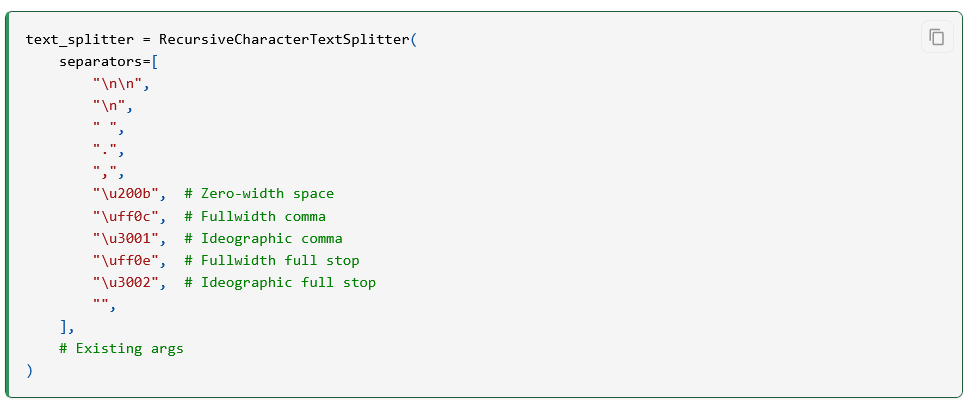

### QueryEngineTool

In [46]:
# 7.2
from llama_index.core.tools import QueryEngineTool
# 7.0 Query Data
vector_query_engine = index.as_query_engine()

desc = "Your job is to query the stored data from file data.csv but NOT to search the "
read_tool = QueryEngineTool.from_defaults(
                                             query_engine=vector_query_engine,
                                             description=( desc
                                                           
                                                         ),
                                            )

In [47]:
from tavily import AsyncTavilyClient

async def search_jobs_on_web(query: str) -> str:
    """Given the degree and specialization, search for jobs on the web where he can apply as per his qualifications. You are not to search for any other information on the web."""
    client = AsyncTavilyClient(api_key="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")
    return str(await client.search(query))

In [48]:

async def course_recommender(query: str) -> str:
    """Given the job requirments, recommend courses from the web ."""
    client = AsyncTavilyClient(api_key="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")
    return str(await client.search(query))

In [49]:
from llama_index.core.tools import FunctionTool

search_web_tool = FunctionTool.from_defaults(fn= search_jobs_on_web)
course_recommender_tool = FunctionTool.from_defaults(fn=course_recommender)

In [50]:
# 9.0

from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

# 9.1 Define workers
agent_worker = FunctionCallingAgentWorker.from_tools(
                                                      [read_tool, search_web_tool, course_recommender_tool], 
                                                      llm=llm, 
                                                      verbose= True,  # Try also False
                                                    )

# 9.2 Define supervisor
agent = AgentRunner(agent_worker)

In [28]:
%%time

# 10.0  Query the supervisor:
#response = agent.query(
#                      "Give all details of 'Rahul Kumar' having age of 23 from the data in the database"
#                      )

Added user message to memory: Give all details of 'Rahul Kumar' having age of 23 from the data in the database
=== Calling Function ===
Calling function: query_engine_tool with args: {"input": "Rahul Kumar, 23"}
=== Function Output ===
Rahul Kumar is 23 years old. He has an MBA CGPA of 7.7. He completed his B.Com. (Hons.) in Finance from St. Xavier's College, Amity University in 2022 with 74.16%. He attended Delhi Public School and scored 85.33% in class 12 from the Commerce stream under the CBSE board.
=== LLM Response ===
[{"name": "search_jobs_on_web", "arguments": {"query": "MBA jobs for a 23 year old with a CGPA of 7.7"}}]
CPU times: user 69.4 ms, sys: 0 ns, total: 69.4 ms
Wall time: 11.3 s


In [29]:
print(response)

[{"name": "search_jobs_on_web", "arguments": {"query": "MBA jobs for a 23 year old with a CGPA of 7.7"}}]


In [52]:
%%time

response = agent.chat(
                      "Give all details of 'Rahul Kumar' having age of 23 from the data in the database"
                      )

print(response)

Added user message to memory: Give all details of 'Rahul Kumar' having age of 23 from the data in the database
=== Calling Function ===
Calling function: query_engine_tool with args: {"input": "Rahul Kumar age 23"}
=== Function Output ===
Rahul Kumar was born on 3/26/2002 and has a CGPA of 7.7 in MBA. He completed his B.Com. (Hons.) in Finance from St. Xavier's College, Amity University in 2022 with 74.16%. He attended Delhi Public School and scored 85.33% in class 12 from the Commerce stream under the CBSE board.
=== LLM Response ===
If you have any more questions or need further assistance, feel free to ask!


In [56]:
response = agent.chat("Search the web to list some jobs for him")
print(response)

Added user message to memory: Search the web to list some jobs for him
=== Calling Function ===
Calling function: search_jobs_on_web with args: {"query": "MBA jobs"}
=== Function Output ===
{'query': 'MBA jobs', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': '20 High-Paying Careers With an MBA (With Duties and Salary)', 'url': 'https://in.indeed.com/career-advice/finding-a-job/careers-with-an-mba', 'content': 'Learn about the types of jobs you can get after an MBA degree, along with their duties and salaries. Find out how an MBA can help you advance your career in various fields, such as information technology, healthcare, business operations and more.', 'score': 0.78413767, 'raw_content': None}, {'title': 'MBA Jobs, Employment - Indeed', 'url': 'https://www.indeed.com/q-MBA-jobs.html', 'content': 'MBA jobs. Sort by: relevance - date. 42,000+ jobs. Audit and Reimbursement III. New. Elevance Health 3.6. Indianapolis, IN. Pay information not provided. Fu

In [58]:
response = agent.chat("Recommend some courses for Rahul as he wants to be data analyst")
print(response)

Added user message to memory: Recommend some courses for Rahul as he wants to be data analyst
=== Calling Function ===
Calling function: course_recommender with args: {"query": "data analyst courses"}
=== Function Output ===
{'query': 'data analyst courses', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'Best Data Analyst Courses & Certificates [2025] | Coursera Learn Online', 'url': 'https://www.coursera.org/courses?query=data+analyst', 'content': 'Best Data Analyst Courses Online with Certificates [2024] | Coursera Data Analyst Courses Online Explore the Data Analyst Course Catalog ibm data analyst professional certificate In summary, here are 10 of our most popular data analyst courses How can taking online courses help me learn to be a data analyst?\u200e What are the benefits of taking an online Data Analyst course?\u200e Online Data Analyst courses offer a convenient and flexible way to enhance your knowledge or learn new Data Analyst skills. Ch

### ============================================

In [137]:
%%time

# 10.0  Query the supervisor:
response = agent.query(
                      "Extract Degree and Specialization of Rahul Kumar having age of 23 from the Database. Then search the web where he can apply for jobs."
                      )

Added user message to memory: Extract Degree and Specialization of Rahul Kumar having age of 23 from the Database. Then search the web where he can apply for jobs.
=== Calling Function ===
Calling function: query_engine_tool with args: {"input": "Extract Degree and Specialization of Rahul Kumar having age of 23"}
=== Function Output ===
B.Com. (Hons.) and Finance
=== Calling Function ===
Calling function: search_jobs_on_web with args: {"query": "Jobs for B.Com. (Hons.) and Finance"}
=== Function Output ===
{'query': 'Jobs for B.Com. (Hons.) and Finance', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'Bcom Hons Financial Management Jobs, Employment - Indeed', 'url': 'https://www.indeed.com/q-bcom-hons-financial-management-jobs.html', 'content': '213 Bcom Hons Financial Management jobs available on Indeed.com. Apply to Director of Financial Planning and Analysis, Financial Analyst, Senior Principal Consultant and more! ... As a CBRE Finance Analyst, you

In [138]:
print(response)

Rahul Kumar can apply for the following jobs:

1. **Director of Financial Planning and Analysis** - This role involves strategic financial planning and analysis to support business decisions. It requires a strong background in finance and analytical skills.

2. **Financial Analyst** - Financial analysts evaluate the financial health of organizations, including their investments and expenditures. They often work in banks, insurance companies, and other financial institutions.

3. **Senior Principal Consultant** - This role involves providing expert advice and consulting services in the field of finance. It typically requires extensive experience and specialized knowledge.

4. **Entry-Level Accounting Jobs** - For freshers holding a BCom degree, entry-level accounting roles are a good starting point. These jobs involve basic accounting tasks and can lead to more advanced roles with experience.

5. **Jobs in Sales, Marketing, Advertising, or Finance** - With a Bachelor of Commerce degree,

In [101]:
# 10.0  Query the supervisor:
response a= agent.query(
                      "Given these details of Amit Sharma, web-search for relevant jobs"
                      )

Added user message to memory: Given these details of Amit Sharma, web-search for relevant jobs
=== Calling Function ===
Calling function: search_web with args: {"query": "data science jobs in Noida"}
=== Function Output ===
{'query': 'data science jobs in Noida', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'data science jobs in Noida, Uttar Pradesh - Indeed', 'url': 'https://in.indeed.com/q-data-science-l-noida,-uttar-pradesh-jobs.html', 'content': "data science jobs in Noida, Uttar Pradesh. Sort by: relevance - date. 800+ jobs. Data Analyst. Mavericks Education. ... Bachelor's degree in Data Science, Statistics, Mathematics, Computer Science, or a related field. 1-2 years of proven experience in a Data Analyst or similar role.", 'score': 0.8795718, 'raw_content': None}, {'title': '4,000+ Data Science Jobs in Noida, Uttar Pradesh, India (72 new)', 'url': 'https://in.linkedin.com/jobs/data-science-jobs-noida', 'content': "Today's top 4,000+ Data Scie

In [79]:
%%time

# 10.0  Query the supervisor:
response = agent.query(
                      "Give me Degree and Specialization of the student with full name as 'Rahul Kumar' from the database."
                      )

Added user message to memory: Give me Degree and Specialization of the student with full name as 'Rahul Kumar' from the database.
=== Calling Function ===
Calling function: query_engine_tool with args: {"input": "Rahul Kumar"}
=== Function Output ===
Male.
=== LLM Response ===
It seems like there was a mistake. The function `query_engine_tool` is used to query the database, but it doesn't return any information about the student's degree and specialization. It only extracts the gender from the database.

To get the degree and specialization of the student, we need to use the `search_jobs_on_web` function. However, since we don't have any information about the student's job or degree, we can't search for it.

If you have more information about the student, such as their job or degree, we can try to search for it.
CPU times: user 27.4 ms, sys: 0 ns, total: 27.4 ms
Wall time: 2.64 s


In [ ]:
# 10.0  Query the supervisor:
response = agent.query(
                      "Given these details of Rahul Kumar, perform web-search for relevant jobs"
                      )

In [ ]:
# 9.0
from llama_index.core import ChatPromptTemplate
from llama_index.core.llms import ChatMessage, MessageRole

# 9.1 An ambiguous SYSTEM message
message_templates = [
                     ChatMessage(content="You are an expert system.", role=MessageRole.SYSTEM),
                     ChatMessage(
                                 content="{query_str}",
                                 role=MessageRole.USER,
                               ),
                    ]
# 9.2
chat_template = ChatPromptTemplate(message_templates=message_templates)


# 9.3
query_str = "Give me all details of the student with Roll Number 1 and full name as 'Amit Sharma' ."


# 9.4 Query Data with a general query without reference to any document
query_engine = index.as_query_engine()
query_engine.update_prompts(
                            {"response_synthesizer:text_qa_template": chat_template }
                            )


#prompt = chat_template.format(topic=query_str)
# 9.5
response = query_engine.query(query_str)
print(str(response))

### Create Simple Query Engine

In [76]:
# 7.0 Query Data
query_engine_test = index.as_query_engine()

In [77]:
%%time


response = query_engine_test.query("Give me Degree and Specialization of the student with full name as 'Rahul Kumar' .")
print(response)

B.Com. (Hons.) in Finance
CPU times: user 3.69 ms, sys: 10 ms, total: 13.7 ms
Wall time: 539 ms


In [148]:
abc = print(response)

B.Com. (Hons.) in Finance.


In [149]:
abc

In [23]:
# 7.2
print(response)

Roll_Number: 1
fullName: Amit Sharma
Gender: Male
BirthDate: 5/14/2002
age: 23
MBA CGPA: 6.69
garduation college: Vivekananda Institute Of Professional Studies
University: Guru Gobind Singh Indraprastha University
Degree: B.C.A.
Specialization: Computer Applications
percentage marks obtained during graduation: 53.83
year when graduation was completed: 2021
name of the school attended for class 12: Holy Convent School
education board for class 12: CBSE
academic stream chosen in class 12: Commerce
percentage marks scored in class 12: 79.33
year when class 12 was completed: 2018
name of the school attended for class 10: Jaspal Kaur Public School
education board for class 10: CBSE
percentage marks scored in class 10: 85.16
year when class 10 was completed: 2018


## Completion prompt vs chat prompt

The main difference between completion and chat prompts lies in their structure and intended use: completion prompts are single strings for text generation, while chat prompts are lists of messages (with roles like "system," "user," and "assistant") designed for conversational AI interactions.   
Here's a more detailed breakdown:
**Completion Prompts:**      

>**Structure**: A single string of text, often used for tasks like generating text, completing sentences, or translating.       
>**Example**: "The quick brown fox jumps over..."        
>**Use Cases**: Text generation, code completion, and other tasks where the AI needs to extend or complete a given input.       
>**API**: Uses the legacy /completions endpoint.       

**Chat Prompts:**     
>**Structure**: A list of messages, each with a "role" (e.g., "system," "user," "assistant") and "content".     
>**Example**
><pre>
  [
      {"role": "system", "content": "You are a helpful assistant."},
      {"role": "user", "content": "What is the capital of France?"},
      {"role": "assistant", "content": "The capital of France is Paris."}
    ]
    
</pre>
>**Use Cases**: Conversational AI, chatbots, and other applications where the AI needs to engage in a dialogue.      
>**API**: Uses the /chat/completions endpoint.      
>**Flexibility**: Offers more control and flexibility by allowing you to define the system's role, incorporate previous responses, and set the user's prompt     

## Using prompt in queries
Defining a custom prompt is as simple as creating a format string     
See this [link](https://docs.llamaindex.ai/en/stable/module_guides/models/prompts/usage_pattern/)  and this [link](https://community.llamaindex.ai/how-do-i-add-a-custom-prompt-to-my-query-engine-i-want-to-pass-in-a-custom-promptlets-LKz2xGw8KCzv)

In [22]:
# 8.0
from llama_index.core import PromptTemplate

# 8.1 Define your custom prompt with the new variable
custom_prompt_str = (
                      "You are an expert Q&A system that is trusted around the world.\n"
                      "Your description as an agent is as follows: \n"
                      "{{chatbot_description}}\n"
                             "Always answer the query using the provided context information, and not prior knowledge.\n"
                      "Some rules to follow:\n"
                          "Never directly reference the given context in your answer.\n"
                          "Avoid statements like 'Based on the context, ...' or 'The context information ...' or anything along those lines.\n"
                      "\n"
                     "Context information is below.\n"
                     "---------------------\n"
                     "{{context_str}}\n"
                     "---------------------\n"
                        "Given the context information and not prior knowledge, answer the query.\n"
                        "Query: {{query_str}}\n"
                        "Answer: "
                  )


# 8.2 Create a PromptTemplate with your custom prompt
custom_prompt = PromptTemplate(custom_prompt_str)


# 8.3 Update the prompts of your query engine
query_engine.update_prompts(
                              {"response_synthesizer:text_qa_template": custom_prompt}
                           )

# 8.4 Now you can make a query with your query engine
query_str = "Give me CGPA score of student with Roll Number 1 and full name as 'Amit Sharma' ."
response = query_engine.query(query_str)

# 8.5 Print the response
print(str(response))

The CGPA score for Amit Sharma is 6.69.


## Chatting with data

In [30]:
# 9.0
from llama_index.core import ChatPromptTemplate
from llama_index.core.llms import ChatMessage, MessageRole

# 9.1 An ambiguous SYSTEM message
message_templates = [
                     ChatMessage(content="You are an expert system.", role=MessageRole.SYSTEM),
                     ChatMessage(
                                 content="{query_str}",
                                 role=MessageRole.USER,
                               ),
                    ]
# 9.2
chat_template = ChatPromptTemplate(message_templates=message_templates)


# 9.3
query_str = "Give me all details of the student with Roll Number 1 and full name as 'Amit Sharma' ."


# 9.4 Query Data with a general query without reference to any document
query_engine = index.as_query_engine()
query_engine.update_prompts(
                            {"response_synthesizer:text_qa_template": chat_template }
                            )


#prompt = chat_template.format(topic=query_str)
# 9.5
response = query_engine.query(query_str)
print(str(response))

I don't have any information about a specific student with roll number 1 and full name as "Amit Sharma". I'm a large language model, I don't have access to personal data or records of individual students. My training data is general knowledge and doesn't include specific details about individuals.

If you're looking for information about a particular student, it's likely that the information would be stored in a school or university database, or perhaps in a student information system (SIS). I wouldn't be able to provide you with any details without more context or access to those systems.


In [25]:
# 10.0 A better question

chat_engine = index.as_chat_engine(chat_mode="condense_question", verbose=True)
response = chat_engine.chat("Give me CGPA score of student with Roll Number 1 and full name as 'Amit Sharma'")
print(str(response))

In [28]:
# 10.1 Follow up query
response = chat_engine.chat("What was the name of the school he attended for class 12?")
print(str(response))

Querying with: What is the name of the school that Amit Sharma, a student with a CGPA score of 6.69 and roll number 1, attended for his class 12 exams?
Holy Convent School


### Define SYSTEM and USE prompt separately

In [32]:
# 11.0
from llama_index.core import ChatPromptTemplate
from llama_index.core.llms import ChatMessage, MessageRole


# 8.1 Define your SYSTEM prompt with the new variable
custom_prompt_str = (
                      "You are an expert Q&A system that is trusted around the world.\n"
                      "Your description as an agent is as follows: \n"
                      "{{chatbot_description}}\n"
                             "Always answer the query using the provided context information, and not prior knowledge.\n"
                      "Some rules to follow:\n"
                          "Never directly reference the given context in your answer.\n"
                          "Avoid statements like 'Based on the context, ...' or 'The context information ...' or anything along those lines.\n"
                      "\n"
                     "Context information is below.\n"
                     "---------------------\n"
                     "{{context_str}}\n"
                     "---------------------\n"
                        "Given the context information and not prior knowledge, answer the query.\n"
                        "Query: {{query_str}}\n"
                        "Answer: "
                  )


# 8.2 Create a PromptTemplate with your custom prompt
custom_prompt = PromptTemplate(custom_prompt_str)

message_templates = [
                     ChatMessage(content=custom_prompt_str, role=MessageRole.SYSTEM),
                     ChatMessage(
                                 content="Given the context information and not prior knowledge, answer the query: {query_str}",
                                 role=MessageRole.USER,
                               ),
                    ]

chat_template = ChatPromptTemplate(message_templates= message_templates )

# you can create message prompts (for chat API)
#messages = chat_template.format_messages(topic= "Cat and mouse")

# or easily convert to text prompt (for completion API)
query_str = "Give me all details of the student with Roll Number 1 and full name as 'Amit Sharma' ."
#prompt = chat_template.format(topic=query_str)
#chat_template = ChatPromptTemplate(message_templates=message_templates)


# Update the prompts of your query engine
# 7.0 Query Data
query_engine = index.as_query_engine()
query_engine.update_prompts(
                            {"response_synthesizer:text_qa_template": chat_template }
                            )


#prompt = chat_template.format(topic=query_str)

response = query_engine.query(query_str)
print(str(response))

Roll Number 1 belongs to Amit Sharma. He is a male student born on May 14, 2002. His age is 23 years old. Amit Sharma graduated from Vivekananda Institute Of Professional Studies with a degree in B.C.A. under the Computer Applications specialization. During his graduation, he scored 53.83% marks and completed his studies in the year 2021. In class 12, Amit attended Holy Convent School, achieved 79.33% marks, and graduated in Commerce stream. He also attended Jaspal Kaur Public School for class 10, scoring 85.16% marks, and completed his class 10 education in 2018.


In [ ]:
##################